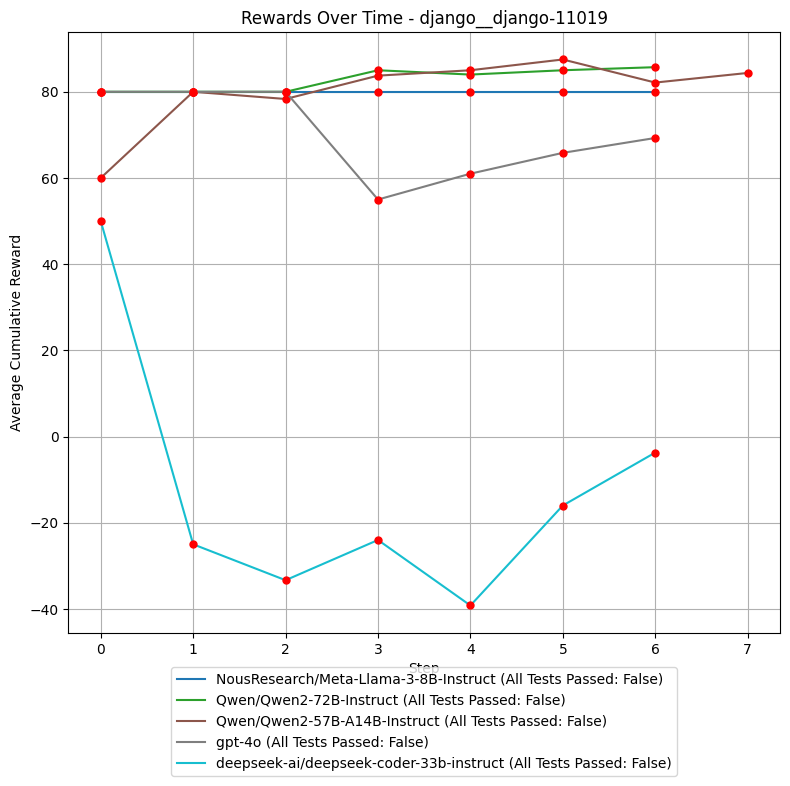

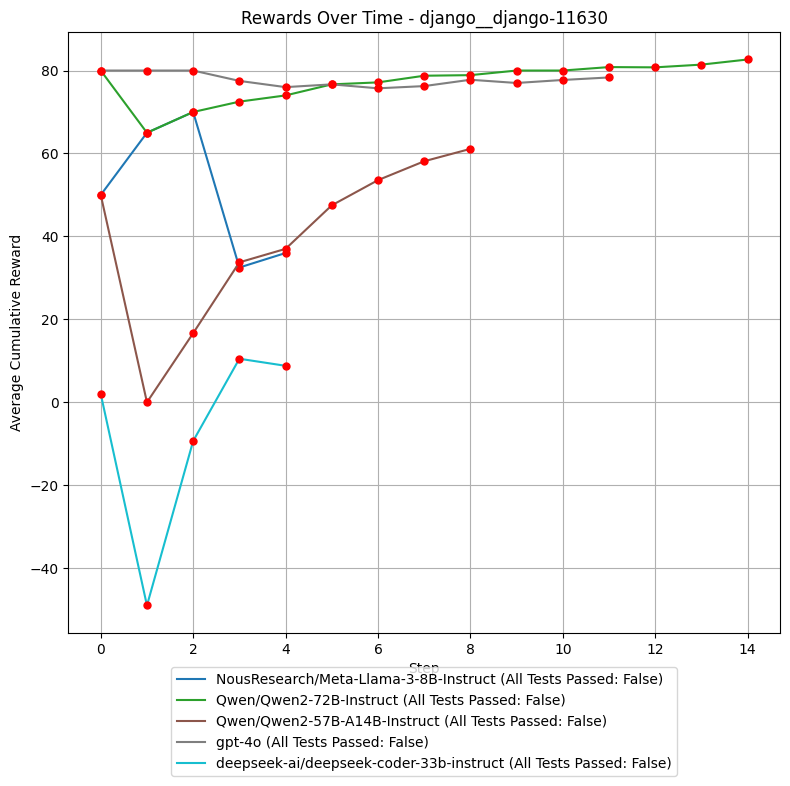

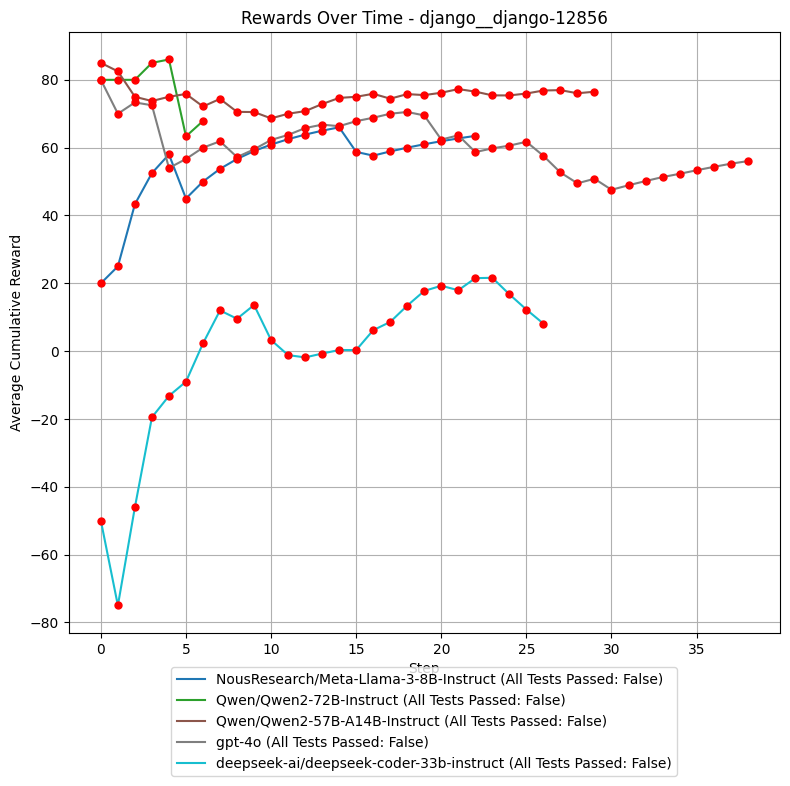

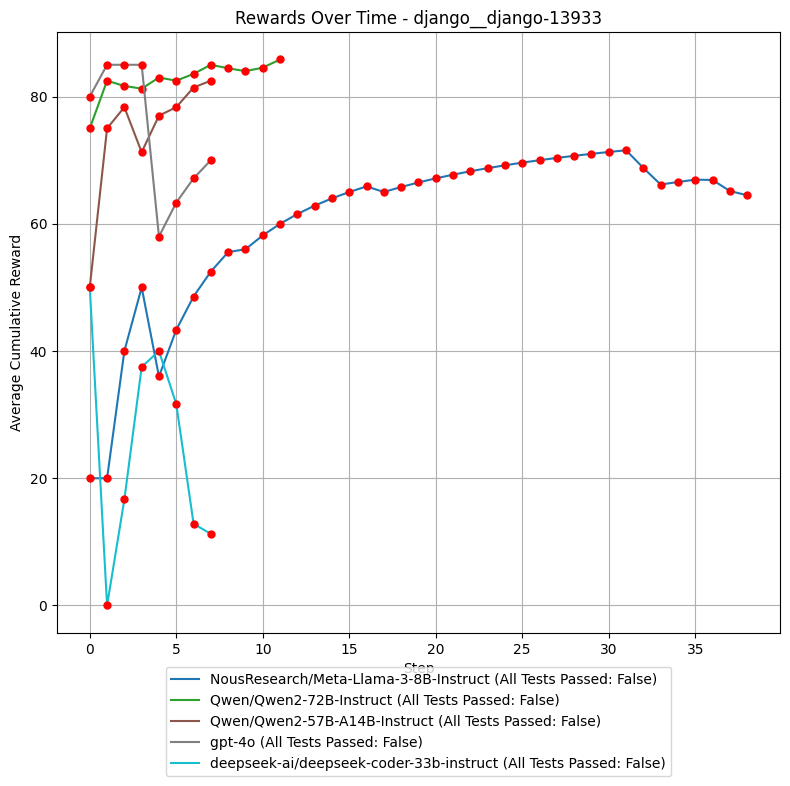

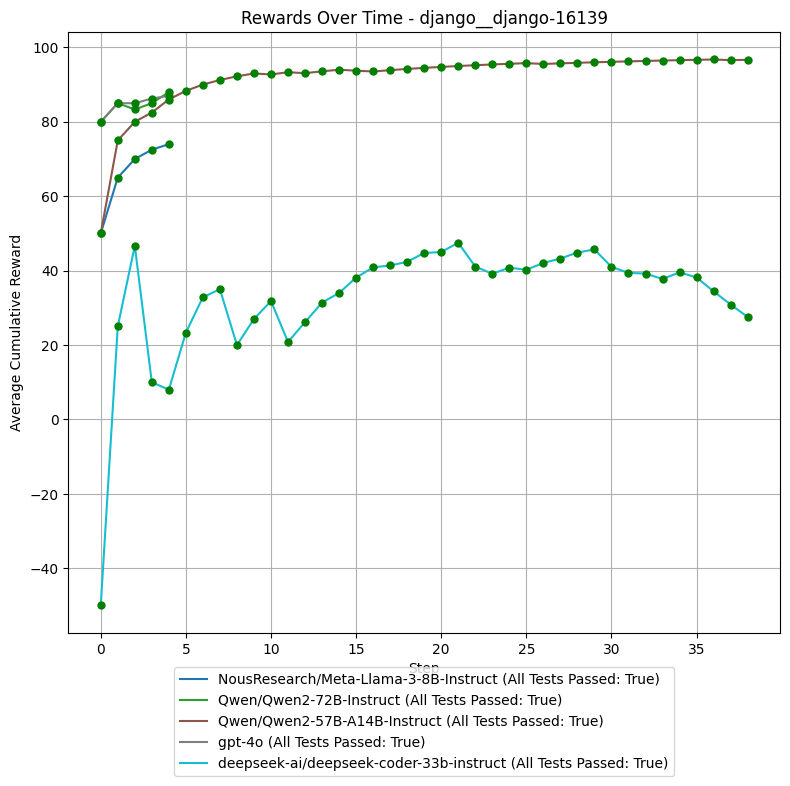

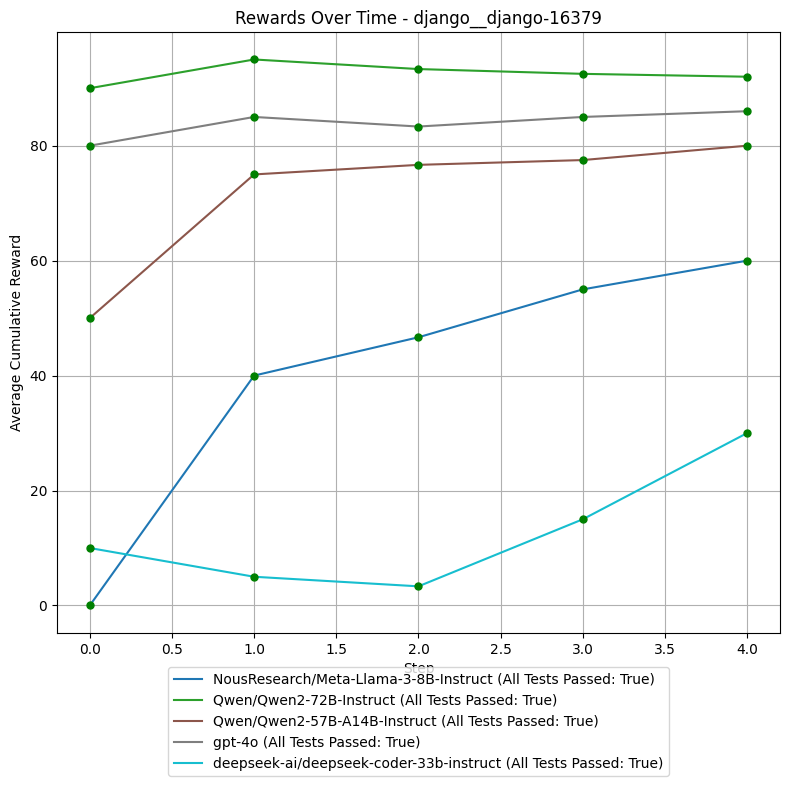

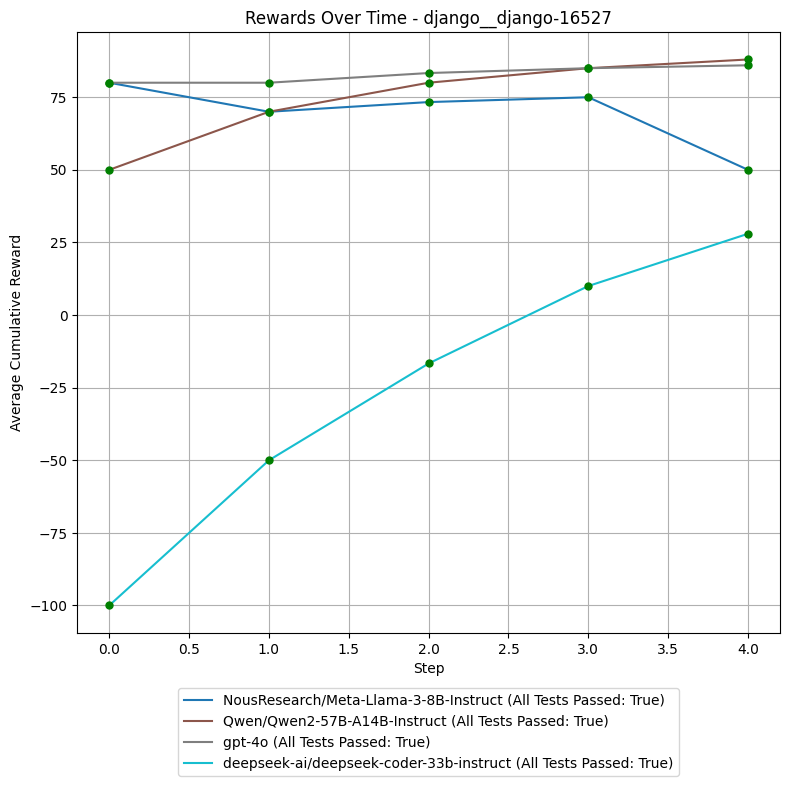

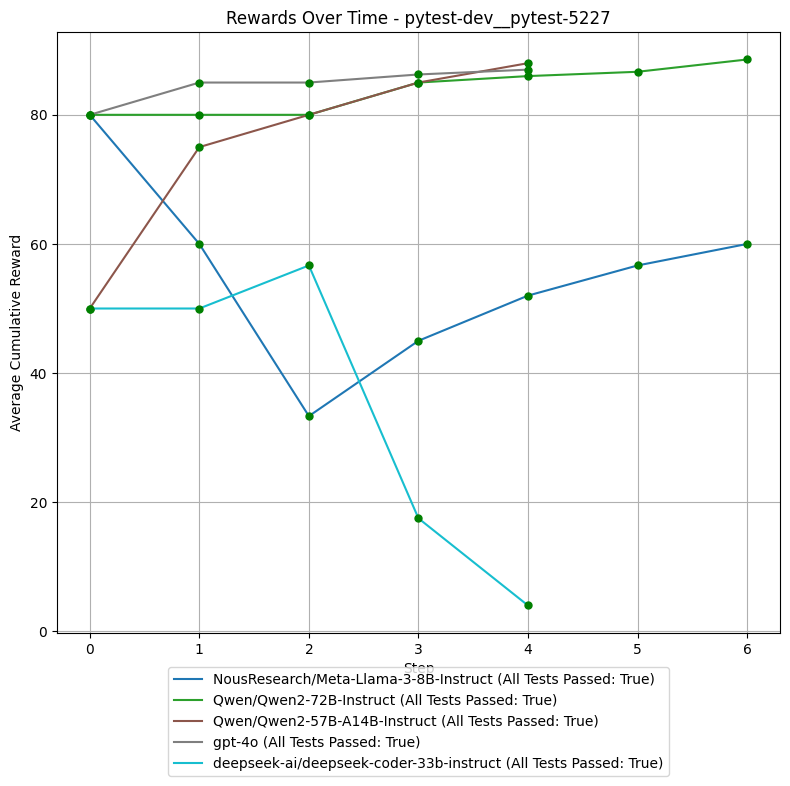

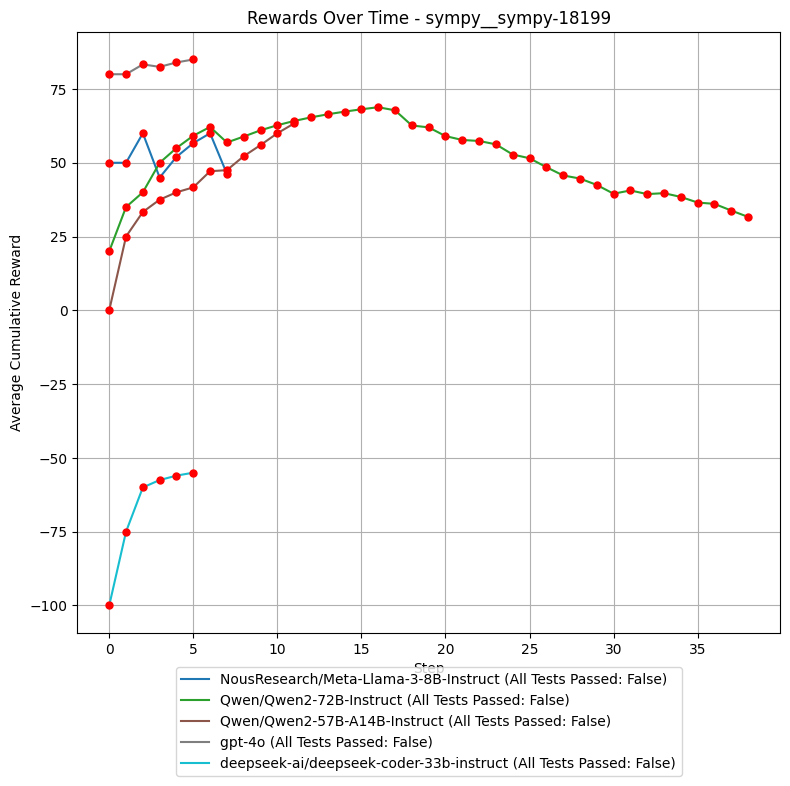

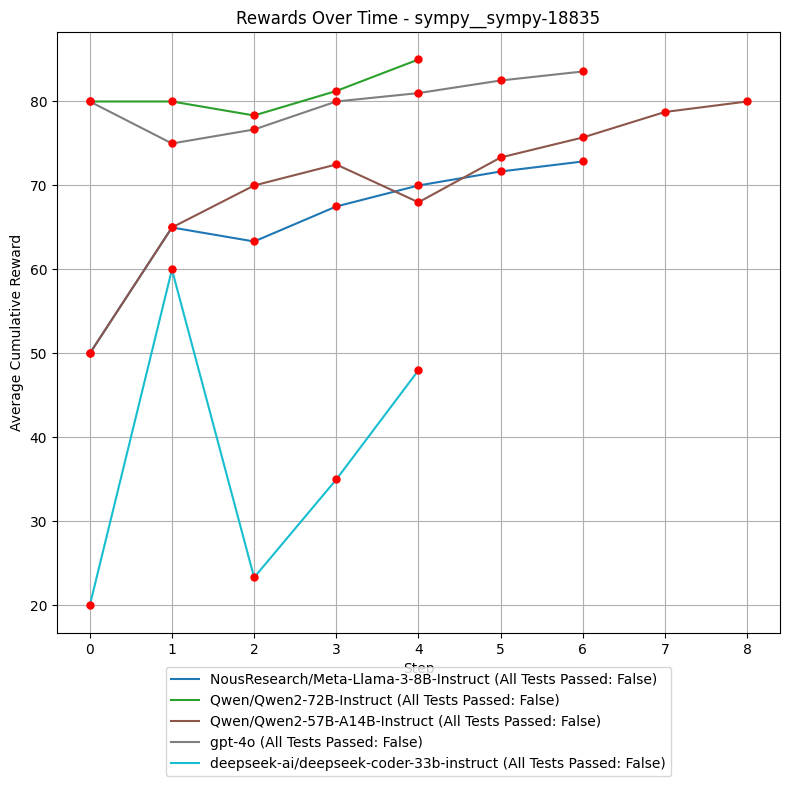

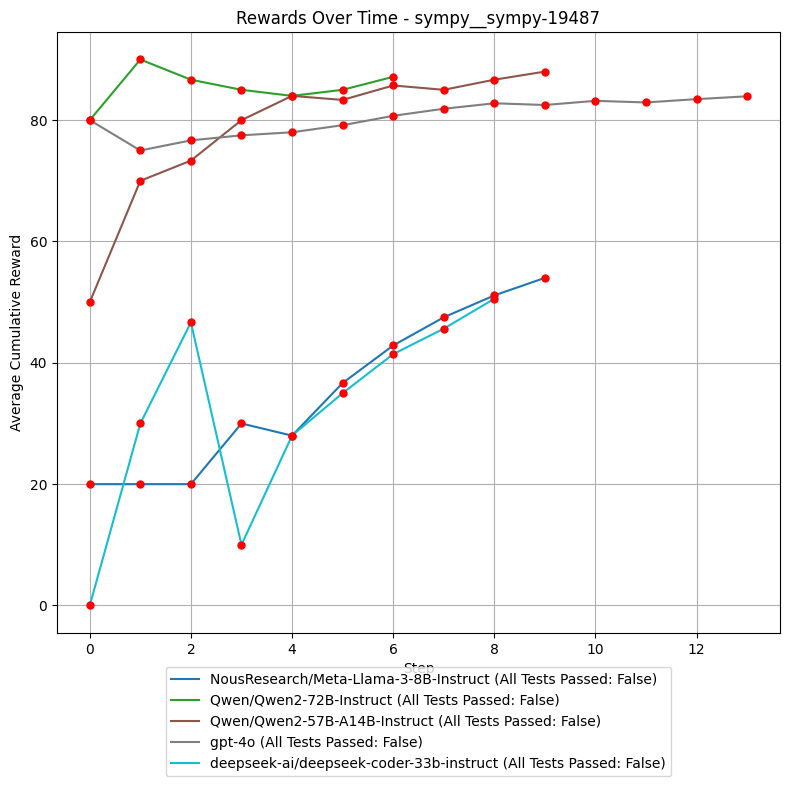

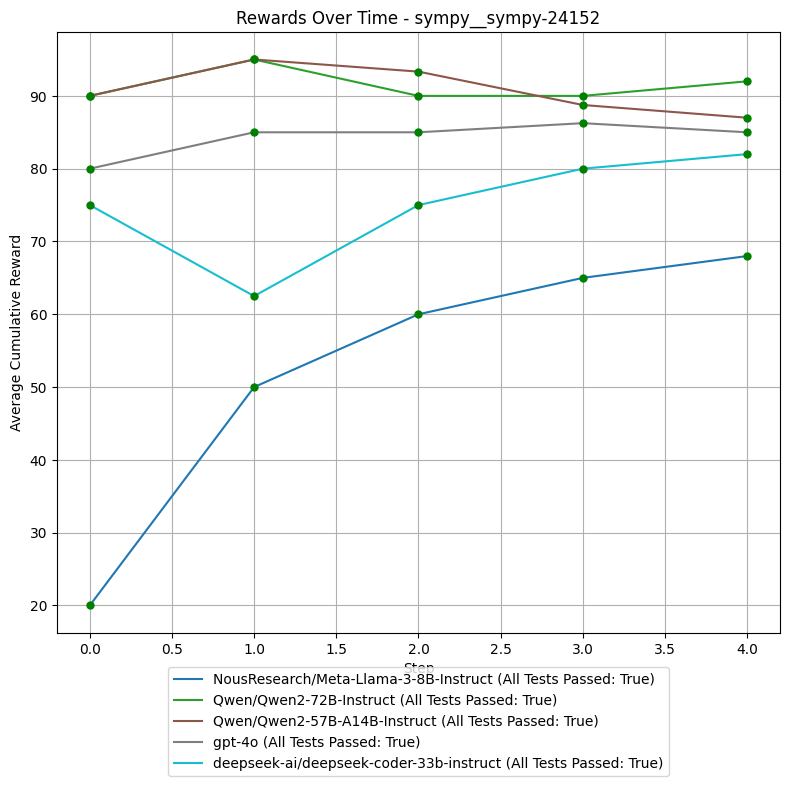

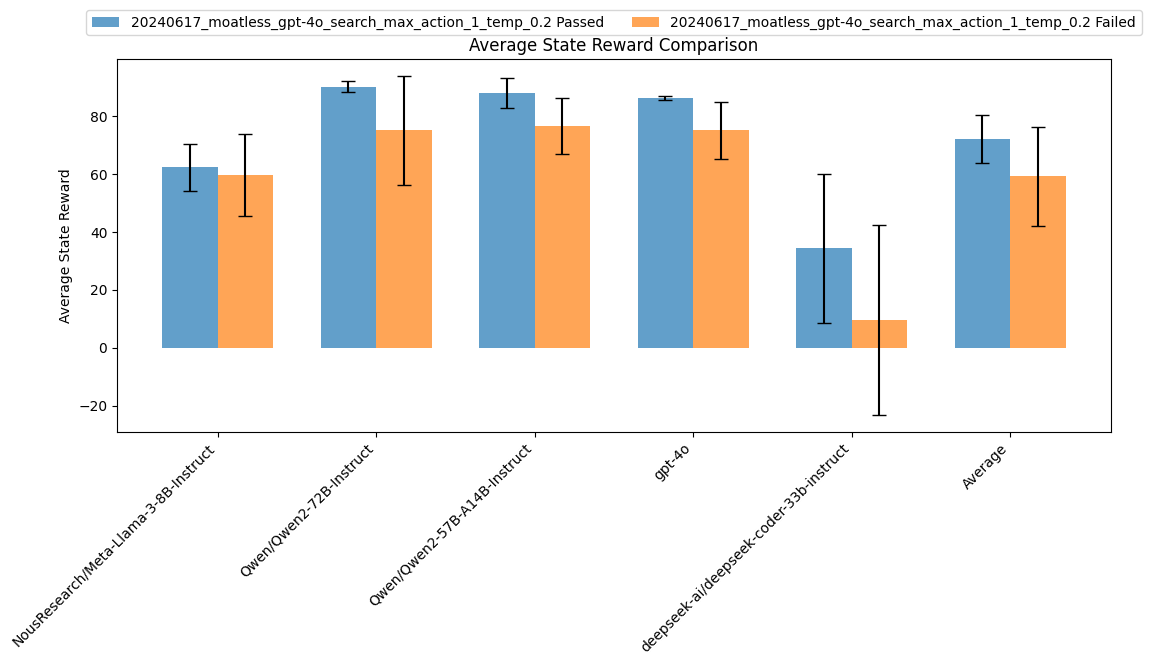

In [9]:
import os
import glob
import math
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Load and parse the rewards
filename = "/share/edc/home/antonis/moatless-tools/evaluations/20240617_moatless_gpt-4o_search_max_action_1_temp_0.2/rews/pytest-dev__pytest-5227.json"


def read_jsonl(file_path):
    with open(file_path, 'r') as file:
        return [json.loads(line) for line in file]
    
def find_instance_names(base_dirs):
    all_instances = set()
    for base_dir in base_dirs:
        # Search for all .json files in the 'rews' directory and its subdirectories
        for filepath in glob.glob(os.path.join(base_dir, 'rews', '**', '*.json'), recursive=True):
            filename = os.path.basename(filepath)
            if filename != 'all_preds.json':
                all_instances.add(filename[:-5])  # Remove '.json' extension
    return sorted(list(all_instances))

def parse_rewards_file(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    
    rewards = defaultdict(list)
    
    for entry in data:
        if not isinstance(entry, dict):
            continue
        node_id = entry['node_id']
        reward = entry['output']['parsed_reward']
        rewards[node_id].append(reward)
    
    return rewards

def plot_all_rewards(data, labels=None, title='Rewards Over Time', xlabel='Step', ylabel='Reward',
                     cumulative=False, normalize=False, figsize=(12, 6), marker='o', grid=True,
                     line_styles=None, colors=None):
    """
    A general function to plot rewards data.
    
    :param data: List of reward data. Each item can be a list, numpy array, or dictionary of rewards.
    :param labels: List of labels for each data set.
    :param title: Title of the plot.
    :param xlabel: Label for x-axis.
    :param ylabel: Label for y-axis.
    :param cumulative: If True, plot cumulative rewards.
    :param normalize: If True and cumulative is True, plot average cumulative rewards.
    :param figsize: Tuple specifying figure size.
    :param marker: Marker style for data points.
    :param grid: If True, show grid on the plot.
    :param line_styles: List of line styles for each data set.
    :param colors: List of colors for each data set.
    """
    plt.figure(figsize=figsize)
    
    for i, rewards in enumerate(data):
        # Convert dict to list if necessary
        if isinstance(rewards, dict):
            rewards = [r for node_rewards in rewards.values() for r in node_rewards]
        
        rewards = np.array(rewards)
        
        if cumulative:
            rewards = np.cumsum(rewards)
            if normalize:
                rewards = rewards / np.arange(1, len(rewards) + 1)
                ylabel = 'Average Cumulative Reward'
            else:
                ylabel = 'Cumulative Reward'
        
        label = labels[i] if labels and i < len(labels) else f'Dataset {i+1}'
        line_style = line_styles[i] if line_styles and i < len(line_styles) else '-'
        color = colors[i] if colors and i < len(colors) else None
        
        plt.plot(rewards, marker=marker, label=label, linestyle=line_style, color=color)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if grid:
        plt.grid(True)
    plt.show()


def plot_rewards_by_node(*reward_sets, labels=None, title='Rewards by Node ID'):
    plt.figure(figsize=(12, 6))
    
    for i, rewards in enumerate(reward_sets):
        for node_id, node_rewards in rewards.items():
            label = f'{labels[i] if labels and i < len(labels) else f"Trajectory {i+1}"} - Node {node_id}'
            plt.plot(node_rewards, marker='o', label=label)
    
    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_all_rewards_for_instance(reward_dict, all_preds, instance, title=None, cumulative=True, normalize=True, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    for model in reward_dict.keys():
        for rew_model in reward_dict[model]:
            if instance in reward_dict[model][rew_model]:
                rewards = reward_dict[model][rew_model][instance]
                all_rewards = [reward for node_rewards in rewards.values() for reward in node_rewards]
                
                if cumulative:
                    all_rewards = np.cumsum(all_rewards)
                    if normalize:
                        all_rewards = all_rewards / np.arange(1, len(all_rewards) + 1)
                        ylabel = 'Average Cumulative Reward'
                    else:
                        ylabel = 'Cumulative Reward'
                else:
                    ylabel = 'Reward'
                
                base_dir = next(dir for dir in all_preds.keys() if model in dir)
                pred_entry = next((pred for pred in all_preds[base_dir] if pred['instance_id'] == instance), None)
                is_successful = pred_entry['is_successful'] if pred_entry else 'Unknown'
                all_tests_passed = pred_entry['test_results'].get('all_tests_passed', False)
                
                label = f"{rew_model} (All Tests Passed: {all_tests_passed})"
                
                # Color line by reward model
                line_color = rew_model_to_color.get(rew_model, 'gray')  # Default to gray if not found
                
                # Plot line
                line, = ax.plot(all_rewards, label=label, color=line_color)
                
                # Color points by correctness
                for i, reward in enumerate(all_rewards):
                    point_color = 'green' if all_tests_passed else 'red'
                    ax.plot(i, reward, marker='o', color=point_color, markersize=5)

    ax.set_title(title or f'Rewards Over Time - {instance}')
    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.grid(True)
    
    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center')
    
    # Adjust the layout to make room for the legend
    plt.tight_layout()
    
    plt.show()
    
def plot_average_reward_bar_chart(reward_dict, all_preds, title="Average State Reward Comparison", figsize=(12, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    reward_models = list(next(iter(reward_dict.values())).keys())
    data = {model: {rew_model: {'passed': [], 'failed': []} for rew_model in reward_models}
            for model in reward_dict.keys()}
    
    for model in reward_dict.keys():
        base_dir = next(dir for dir in all_preds.keys() if model in dir)
        for instance in reward_dict[model][reward_models[0]].keys():
            pred_entry = next((pred for pred in all_preds[base_dir] if pred['instance_id'] == instance), None)
            all_tests_passed = pred_entry['test_results'].get('all_tests_passed', False) if pred_entry else False
            for rew_model in reward_models:
                if instance in reward_dict[model][rew_model]:
                    rewards = reward_dict[model][rew_model][instance]
                    avg_reward = np.mean([reward for node_rewards in rewards.values() for reward in node_rewards])
                    if all_tests_passed:
                        data[model][rew_model]['passed'].append(avg_reward)
                    else:
                        data[model][rew_model]['failed'].append(avg_reward)
    
    x = np.arange(len(reward_models) + 1)  # +1 for the average
    width = 0.35
    
    # Calculate averages across all models
    avg_data = {rew_model: {'passed': [], 'failed': []} for rew_model in reward_models}
    for model in reward_dict.keys():
        for rm in reward_models:
            avg_data[rm]['passed'].extend(data[model][rm]['passed'])
            avg_data[rm]['failed'].extend(data[model][rm]['failed'])
    
    passed_means = [np.mean(data[model][rm]['passed']) if data[model][rm]['passed'] else 0 for rm in reward_models]
    failed_means = [np.mean(data[model][rm]['failed']) if data[model][rm]['failed'] else 0 for rm in reward_models]
    passed_stds = [np.std(data[model][rm]['passed']) if data[model][rm]['passed'] else 0 for rm in reward_models]
    failed_stds = [np.std(data[model][rm]['failed']) if data[model][rm]['failed'] else 0 for rm in reward_models]
    
    # Add average across all models
    passed_means.append(np.mean([np.mean(avg_data[rm]['passed']) for rm in reward_models if avg_data[rm]['passed']]))
    failed_means.append(np.mean([np.mean(avg_data[rm]['failed']) for rm in reward_models if avg_data[rm]['failed']]))
    passed_stds.append(np.mean([np.std(avg_data[rm]['passed']) for rm in reward_models if avg_data[rm]['passed']]))
    failed_stds.append(np.mean([np.std(avg_data[rm]['failed']) for rm in reward_models if avg_data[rm]['failed']]))
    
    ax.bar(x - width/2, passed_means, width, label=f'{model} Passed', alpha=0.7, yerr=passed_stds, capsize=5)
    ax.bar(x + width/2, failed_means, width, label=f'{model} Failed', alpha=0.7, yerr=failed_stds, capsize=5)
    
    ax.set_ylabel('Average State Reward')
    ax.set_title(title)
    ax.set_xticks(x)
    labels = reward_models + ['Average']
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
    plt.tight_layout()
    plt.show()

def print_reward_statistics(*reward_sets, labels=None):
    for i, rewards in enumerate(reward_sets):
        all_rewards = [reward for node_rewards in rewards.values() for reward in node_rewards]
        label = labels[i] if labels and i < len(labels) else f'Trajectory {i+1}'
        
        print(f"\nStatistics for {label}:")
        print(f"Total number of rewards: {len(all_rewards)}")
        print(f"Mean reward: {np.mean(all_rewards):.2f}")
        print(f"Median reward: {np.median(all_rewards):.2f}")
        print(f"Standard deviation: {np.std(all_rewards):.2f}")
        print(f"Min reward: {np.min(all_rewards):.2f}")
        print(f"Max reward: {np.max(all_rewards):.2f}")


# Modify the base_dirs and rew_models lists
base_dirs = [
    "/share/edc/home/antonis/moatless-tools/evaluations/20240617_moatless_gpt-4o_search_max_action_1_temp_0.2",
    # "/share/edc/home/antonis/moatless-tools/evaluations/20240617_moatless_gpt-3.5-turbo_search_max_action_1_temp_0.2"
]
rew_models = ["NousResearch/Meta-Llama-3-8B-Instruct",
              "Qwen/Qwen2-72B-Instruct", "Qwen/Qwen2-57B-A14B-Instruct",
              "gpt-4o", "deepseek-ai/deepseek-coder-33b-instruct"]
instances = ["pytest-dev__pytest-5227", "django__django-16139", "sympy__sympy-24152", 
             "django__django-16379", "django__django-16527", "django__django-13933"]

rew_model_colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(rew_models)))
rew_model_to_color = {rew_model: rew_model_colors[i] for i, rew_model in enumerate(rew_models)}

instances = find_instance_names(base_dirs)

all_preds = {base_dir: read_jsonl(os.path.join(base_dir, "all_preds_.jsonl")) for base_dir in base_dirs}

# Modify the reward_dict structure
reward_dict = {}

for base_dir in base_dirs:
    model = base_dir.split("/")[-1]
    reward_dict[model] = {}
    for rew_model in rew_models:
        reward_dict[model][rew_model] = {}
        for instance in instances:
            filename = f"{base_dir}/rews/{rew_model}/{instance}.json"
            if not os.path.exists(filename):
                continue
            rewards = parse_rewards_file(filename)
            reward_dict[model][rew_model][instance] = rewards

# for instance in instances:
#     for rew_model in rew_models:
#         reward_data = [reward_dict[model][rew_model][instance] 
#                        for model in reward_dict.keys() 
#                        if rew_model in reward_dict[model] and instance in reward_dict[model][rew_model]]
#         labels = [f"{model} - {rew_model}" for model in reward_dict.keys() 
#                   if rew_model in reward_dict[model] and instance in reward_dict[model][rew_model]]
        
#         plot_all_rewards(reward_data, labels=labels, 
#                          title=f'Rewards Over Time - {instance} - {rew_model}',
#                          cumulative=True, normalize=True,
#                          line_styles=['-', '--'],  # Different line styles for different models
#                          colors=['blue', 'red'])  # Different colors for different models

# In the main code:
for instance in instances:
    plot_all_rewards_for_instance(reward_dict, all_preds, instance, cumulative=True, normalize=True)

plot_average_reward_bar_chart(reward_dict, all_preds)

# # Modify the statistics printing loop
# for instance in instances:
#     for rew_model in rew_models:
#         reward_sets = [reward_dict[model][rew_model][instance] 
#                        for model in reward_dict.keys() 
#                        if rew_model in reward_dict[model] and instance in reward_dict[model][rew_model]]
#         labels = [f"{model} - {rew_model}" for model in reward_dict.keys() 
#                   if rew_model in reward_dict[model] and instance in reward_dict[model][rew_model]]
        
#         print(f"\nStatistics for instance: {instance}, Reward Model: {rew_model}")
#         print_reward_statistics(*reward_sets, labels=labels)
        

In [8]:
reward_dict['20240617_moatless_gpt-4o_search_max_action_1_temp_0.2']['Qwen/Qwen2-7B-Instruct']

{'django__django-11019': defaultdict(list,
             {2: [80],
              3: [80],
              4: [80],
              5: [100],
              6: [80],
              7: [95],
              8: [80],
              9: [95],
              10: [85],
              11: [80],
              12: [80],
              13: [85],
              14: [80],
              15: [90],
              16: [90]}),
 'django__django-11630': defaultdict(list,
             {2: [80], 3: [80], 4: [85], 5: [100], 6: [60], 7: [50], 8: [80]}),
 'django__django-12856': defaultdict(list,
             {2: [100],
              3: [75],
              4: [75],
              5: [80],
              6: [95],
              7: [85],
              8: [80],
              9: [80],
              10: [85],
              11: [60],
              12: [80],
              13: [60],
              14: [80],
              15: [20],
              16: [100],
              17: [75],
              18: [80],
              19: [100],
         